# Many to Many 
* 자연어 처리에서 형태소 분석, 객체명 인식 등에 활용  
* 각각에 대해 모두 출력을 하는 구조 
* 토큰화 --> 태깅 
* padding
* masking 

In [60]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.1.0


#### 데이터 준비 

In [61]:
# 문장 준비 
sentences = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]

# 문법
pos = [['pronoun', 'verb', 'adjective'],
     ['noun', 'verb', 'adverb', 'adjective'],
     ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
     ['noun', 'verb', 'adverb', 'adjective', 'verb']]

#### 데이터 전처리 
* 중복되지 않은 원소를 갖는 하나의 리스트 생성하기 
* word2idx : {워드 : 인덱스 } 형태의 딕셔너리 생성 
* idx2word : {인덱스 : 워드 } 형태의 딕셔너리 생성 

In [62]:
print(type(sentences))
# 중복되지 않은 원소를 갖는 하나의 리스트 생성하기 
word_list = sum(sentences, [])       # 하나의 리스트로 생성 
word_list = sorted(set(word_list))   # 집합으로 만들고 정렬함 
word_list = ['<pad>'] + word_list    # 리스트 맨 앞에 <pad> 추가 

# {워드 : 인덱스 } 형태의 딕셔너리 생성 
word2idx = {word : idx for idx, word in enumerate(word_list)}

# {인덱스 : 워드 } 형태의 딕셔너리 생성 
idx2word = {idx : word for idx, word in enumerate(word_list)}

print(word_list)
print(word2idx)
print(idx2word)
print(len(idx2word))

<class 'list'>
['<pad>', 'I', 'a', 'changing', 'deep', 'difficult', 'fast', 'feel', 'for', 'framework', 'hungry', 'is', 'learning', 'tensorflow', 'very']
{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}
15


#### 품사를 위한 토큰 사전 

In [63]:
pos_list = sum(pos, [])           # 하나의 리스트로 생성 
pos_list = sorted(set(pos_list))  # 집합으로 만들고 정렬함 
pos_list = ['<pad>'] + pos_list   # 리스트 맨 앞에 <pad> 추가 

idx2pos = {idx : pos for idx, pos in enumerate(pos_list)}
pos2idx = {pos : idx for idx, pos in enumerate(pos_list)}

print(pos_list)
print(idx2pos)
print(pos2idx)

['<pad>', 'adjective', 'adverb', 'determiner', 'noun', 'preposition', 'pronoun', 'verb']
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}
{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}


#### 토큰 시퀀스를 인덱스 시퀀스로 변환하고 패딩하기 
* sentence를 word의 시퀀스로 간주하고 문제를 해결
* 토큰인 word를 integer index로 맵핑하고 있는 토큰의 딕셔너리를 만듦
* 정답이 품사의 시퀀스 형태로 주어져 있기 때문에 품사를 integer index로 맵핑하고 있는 딕셔너리 만듦
* 입력과 출력의 길이가 같음을 표현하기 위해서 각각의 딕셔너리에는 pad 토큰이 포함되어 있습니다.
* 각각의 integer index의 시퀀스를 pad_sequences function을 이용하여 max_sequence가 가리키고 있는 값만큼의 길이로 padding 합니다. 
* x_data_len : 각 문장의 길이 

In [64]:
max_sequence = 10
x_data = list(map(lambda sentence : [word2idx.get(token) for token in sentence], sentences))
y_data = list(map(lambda sentence : [pos2idx.get(token) for token in sentence], pos))

# 패딩 
x_data = pad_sequences(sequences=x_data, maxlen=max_sequence, padding='post', truncating='post')
x_data_mask = ((x_data != 0) * 1).astype(np.float32)
x_data_len = list(map(lambda sentence : len(sentence), sentences))

y_data = pad_sequences(sequences=y_data, maxlen=max_sequence, padding='post', truncating='post')

print(x_data, x_data_len)
print(y_data)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]] [3, 4, 7, 5]
[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


#### 모델 생성 (many to many : sequence tagging)

In [65]:
num_classes = len(pos2idx)   # 결과 종류 
hidden_dim = 10

input_dim = len(word2idx)
output_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

print(num_classes)
print(input_dim)
print(output_dim)
print(one_hot)

8
15
15
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


#### 모델 
* embedding layer의 경우 이전 예제들과 동일한 방식 즉 토큰을 one hot vector로 표현하고 embedding layer를 학습시키지 않으며 0으로 padding된 부분을 연산에서 제외하는 방식으로 활용 
* return_sequences=True : RNN이 있는 모든 토큰에 대해서 출력을 내어 줌
* 토큰(워드)는 숫자가 아니기 때문에 Embedding레이어를 이용하여 숫자로 처리할 수 있도록 변환 
* TimeDistributed와 Dense를 이용하여 매 토큰마다 품사가 무엇인지 classification을 하는 형태로 RNN을 many to many 방식으로 활용하는 구조를 완성

In [66]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True, trainable=False, input_length=max_sequence,
                             embeddings_initializer=tf.keras.initializers.Constant(one_hot)),
    tf.keras.layers.SimpleRNN(units=hidden_dim, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=num_classes))
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 15)            225       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 10, 10)            260       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 8)             88        
Total params: 573
Trainable params: 348
Non-trainable params: 225
_________________________________________________________________


#### 모델 학습 
* 매 토큰마다 loss를 계산
* masking : 데이터의 시퀀스를 구성하는 토큰들 중에서 길이를 맞춰주기 위해 존재할 뿐인 pad 토큰에 대해서는 loss를 계산하지 않겠다는 개념 
* element-wise 연산으로 마스킹을 반영

In [67]:
# 손실 함수 정의 
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    valid_time_step = tf.cast(x_len, dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=model(x), from_logits=True) * masking
    sequence_loss = tf.reduce_sum(sequence_loss, axis=-1) / valid_time_step
    sequence_loss = tf.reduce_mean(sequence_loss)
    
    return sequence_loss

#하이퍼 파라미터 
lr = 0.1              # 학습률 확인 
epochs = 30           # 학습 횟수 
batch_size = 2        # 배치 크기 
opt = tf.keras.optimizers.Adam(learning_rate=lr)

#### 학습 데이터 

In [68]:
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len)) # 데이터셋 자르기  
tr_dataset = tr_dataset.shuffle(buffer_size=4)                                # 섞기 
tr_dataset = tr_dataset.batch(batch_size=2)

print(tr_dataset)

<BatchDataset shapes: ((None, 10), (None, 10), (None,)), types: (tf.int32, tf.int32, tf.int32)>


* many to many에서는 Sequence loss 를 계산함 
* loss function이 시퀀스의 유효한 길이와 max_sequences를 입력으로 받고 있음
* with 블록에서 mini batch마다의 시퀀스 loss를 계산하고 그 아래에 있는 코드로 Gradient를 계산하고 이를 이용하여 optimizer가 Gradient Descent를 하는 구조

In [69]:
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb, x_mb_len in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, x_len=x_mb_len, max_sequence=max_sequence)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   5, tr_loss : 0.142
epoch :  10, tr_loss : 0.010
epoch :  15, tr_loss : 0.002
epoch :  20, tr_loss : 0.001
epoch :  25, tr_loss : 0.001
epoch :  30, tr_loss : 0.001


In [70]:
print(x_data_mask)
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1) * x_data_mask

from pprint import pprint
pprint(list(map(lambda row : [idx2pos.get(elm) for elm in row], yhat.astype(np.int32).tolist())), width=120)
pprint(pos)

[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[['pronoun', 'verb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


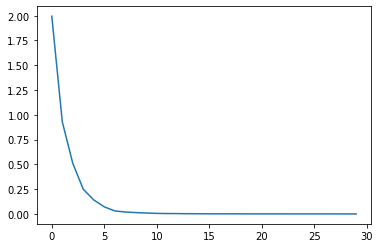

In [71]:
plt.plot(tr_loss_hist)